# C964 Project Exploratory Analysis

## Setup

In [5]:
import warnings

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox, pointbiserialr, yeojohnson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("mako"))
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
# Metadata file manually encodes the variable type for each column used in the analysis
meta = pd.read_csv("../data/meta.csv")
meta

,variable,section,kind
0,REGIONC,GEOGRAPHY,categorical
1,DIVISION,GEOGRAPHY,categorical
2,STATE_FIPS,GEOGRAPHY,categorical
3,state_postal,GEOGRAPHY,categorical
4,state_name,GEOGRAPHY,categorical
...,...,...,...
258,BTUEL,End-use Model,numerical
259,BTUNG,End-use Model,numerical
260,BTULP,End-use Model,numerical
261,BTUFO,End-use Model,numerical


In [7]:
# Import survey response dataset
data = pd.read_csv(
    "../data/recs2020_public_v5.csv", usecols=meta["variable"], na_values=["-2", "."]
)

# Split the dataset into training and test sets
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Use the training set for further analysis
households = train_set.copy()
households

,REGIONC,DIVISION,STATE_FIPS,state_postal,state_name,BA_climate,IECC_climate_code,UATYP10,HDD65,CDD65,...,TOTCSQFT,BTUEL,BTUNG,BTULP,BTUFO,BTUWD,TOTALBTU,DBT1,DBT99,GWT
18412,SOUTH,West South Central,5,AR,Arkansas,Mixed-Humid,3A,U,2858,2034,...,180,15060.68,0.00,0.00,0.0,0.0,15060.68,96.8,21.7,60.7
4909,MIDWEST,West North Central,20,KS,Kansas,Mixed-Humid,4A,R,4228,1539,...,1080,15909.12,0.00,63956.58,0.0,0.0,79865.70,93.4,13.9,56.7
10031,SOUTH,East South Central,47,TN,Tennessee,Mixed-Humid,4A,U,3184,1594,...,1710,22454.94,22176.54,0.00,0.0,0.0,44631.48,90.4,20.9,58.9
9859,MIDWEST,West North Central,29,MO,Missouri,Mixed-Humid,4A,C,3061,1892,...,2400,101906.49,0.00,0.00,0.0,0.0,101906.49,94.7,17.4,61.4
10359,WEST,Mountain South,35,NM,New Mexico,Mixed-Dry,4B,U,3890,1647,...,2150,23543.51,32815.46,0.00,0.0,0.0,56358.97,92.9,21.6,58.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,SOUTH,South Atlantic,37,NC,North Carolina,Mixed-Humid,4A,U,3179,1481,...,1460,39236.61,0.00,0.00,0.0,0.0,39236.61,90.4,22.2,60.2
11964,MIDWEST,West North Central,27,MN,Minnesota,Very-Cold,7A,R,9083,299,...,0,49532.28,0.00,76867.06,0.0,0.0,126399.34,81.3,-12.5,39.7
5390,SOUTH,South Atlantic,37,NC,North Carolina,Mixed-Humid,4A,C,2549,1867,...,2990,52629.83,0.00,0.00,0.0,0.0,52629.83,91.4,23.3,62.2
860,MIDWEST,East North Central,39,OH,Ohio,Cold,5A,U,5776,648,...,3000,25395.79,87576.54,0.00,0.0,0.0,112972.33,85.8,7.9,49.6


In [8]:
# Categorize variable by type
numerical_vars = meta.query("`kind` == 'numerical'")["variable"].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")["variable"].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")["variable"].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")["variable"].tolist()

# Display count of variable by type
print("numerical_vars", len(numerical_vars))
print("boolean_vars", len(boolean_vars))
print("ordinal_vars", len(ordinal_vars))
print("categorical_cars", len(categorical_vars))

numerical_vars 88
boolean_vars 87
ordinal_vars 35
categorical_cars 53


## Data analysis

### Target variables

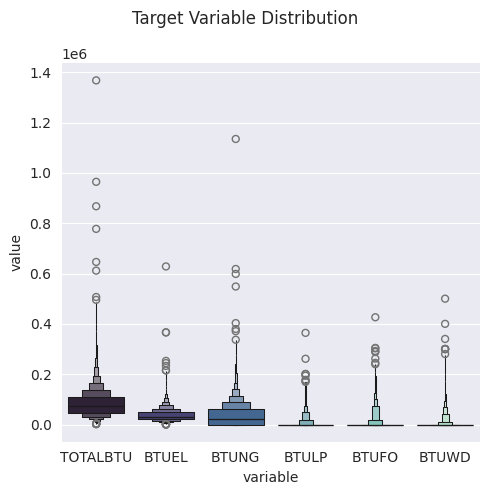

In [9]:
target_vars = meta.query("`section` == 'End-use Model'")["variable"].tolist()

# Display the distribution of target variables as a letter-value plot
melted = households[target_vars].melt()
g = sns.catplot(
    data=melted, x="variable", y="value", hue="variable", legend=False, kind="boxen"
)
g.fig.suptitle("Target Variable Distribution")
g.fig.tight_layout()
plt.show()

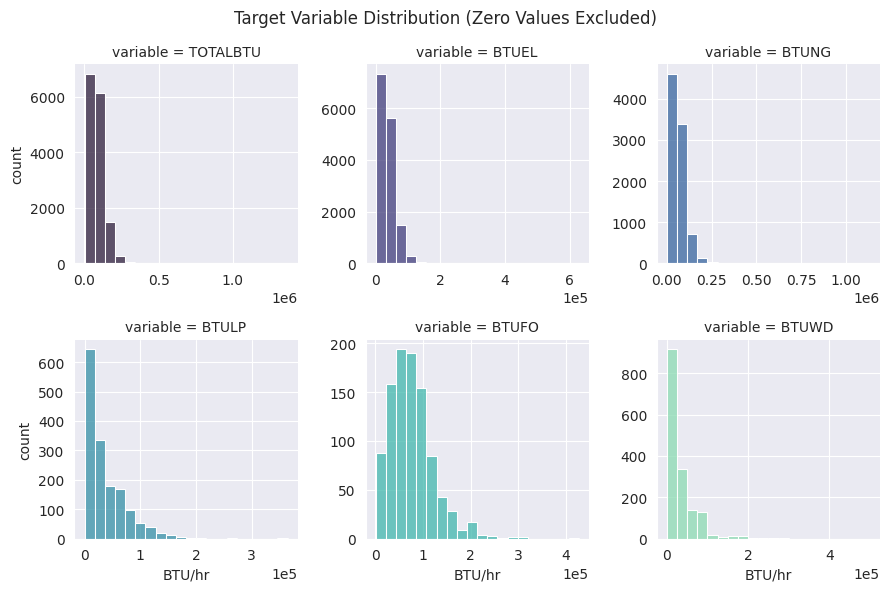

In [33]:
def plot_hist(cols, title, xlabel=None):
    melted = households[cols].melt()
    melted = melted[melted["value"] > 0]

    g = sns.FacetGrid(
        data=melted,
        col="variable",
        hue="variable",
        col_wrap=3,
        sharex=False,
        sharey=False,
    )
    g.map(sns.histplot, "value", bins=20)
    g.set_axis_labels(xlabel, "count")
    g.fig.suptitle(title)
    g.fig.tight_layout()
    return g


# Plot the distribution of target variables, without zero values
g = plot_hist(
    target_vars, "Target Variable Distribution (Zero Values Excluded)", "BTU/hr"
)
for ax in g.axes.flat:
    ax.ticklabel_format(axis="x", style="scientific", scilimits=(0, 0))
plt.show()

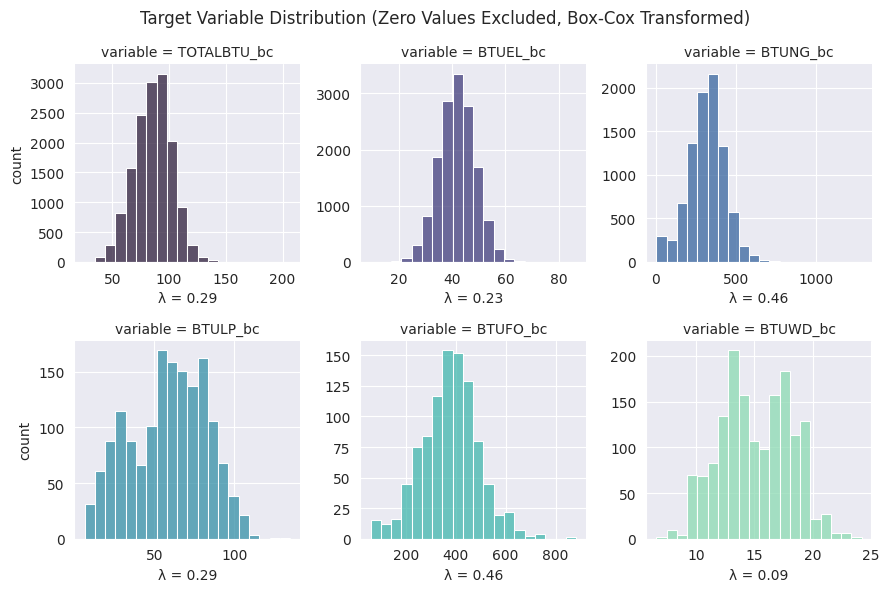

In [7]:
for col in target_vars:
    non_zero_rows = households[col] > 0
    transformed, lmda = boxcox(households.loc[non_zero_rows, col])
    households.loc[non_zero_rows, f"{col}_bc"] = transformed
    households.loc[~non_zero_rows, f"{col}_bc"] = 0
    households[f"{col}_lambda"] = [lmda] * len(households)

target_vars_bc = [f"{col}_bc" for col in target_vars]

# Plot the distribution of target variables after application of a Box-Cox transformation, along with the corresponding lambda values
g = plot_hist(
    target_vars_bc,
    "Target Variable Distribution (Zero Values Excluded, Box-Cox Transformed)",
    "BTU/hr",
)
for var, axes in g.axes_dict.items():
    lmda = households[var.replace("_bc", "_lambda")].iloc[0]
    axes.set(xlabel=f"λ = {lmda:.2f}")

g.fig.subplots_adjust(hspace=0.4)
plt.show()

### Geographic variables

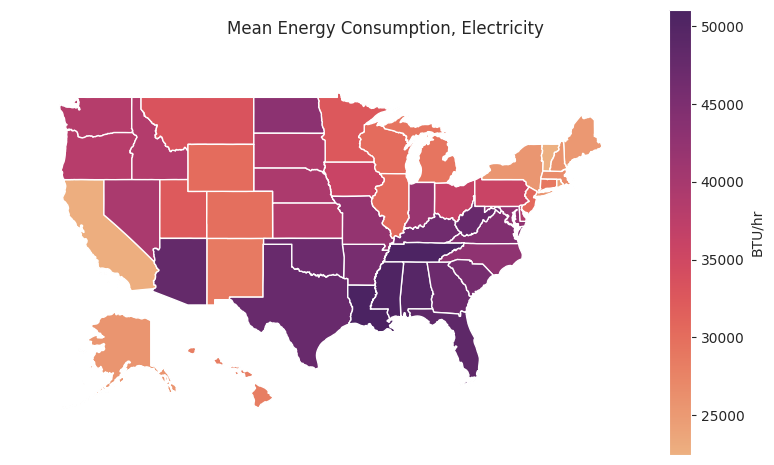

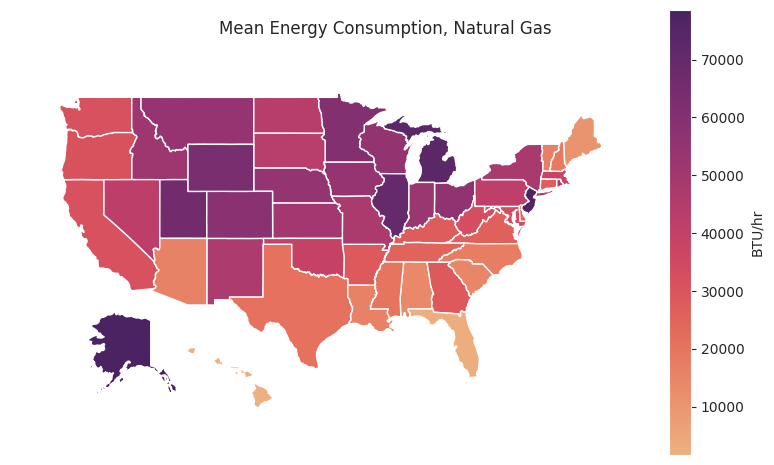

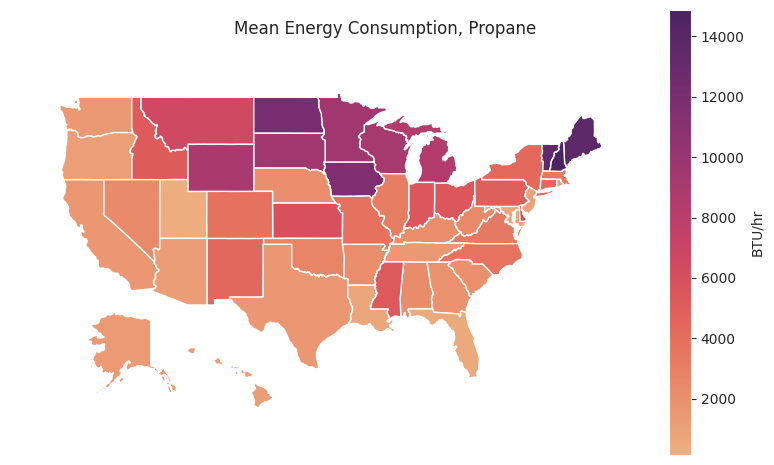

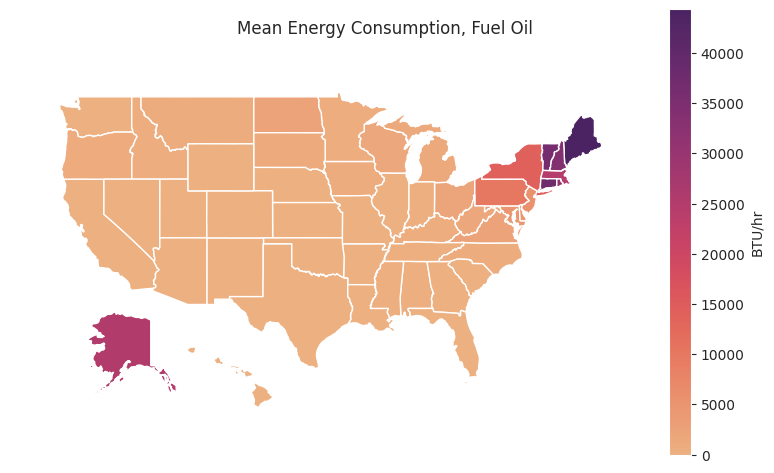

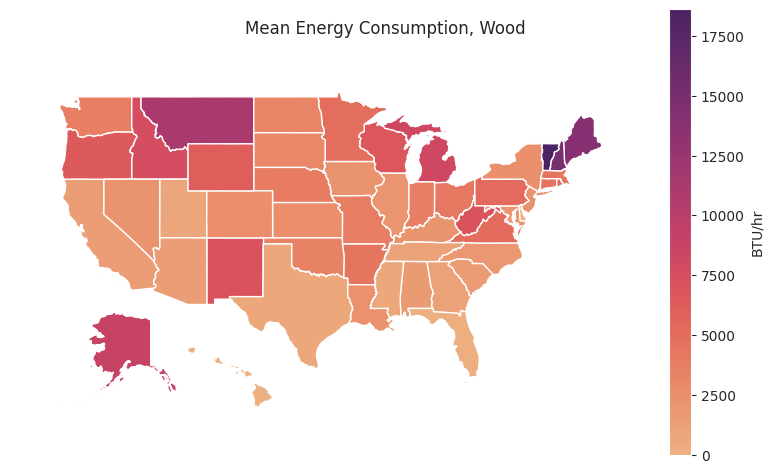

In [8]:
# Download the US states shapefile from the US Census Bureau
us_states = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
)[["STUSPS", "geometry"]]
us_states.rename(columns={"STUSPS": "state_postal"}, inplace=True)
us_states.set_index("state_postal", inplace=True)


def plot_geo(target_col, title, unit, palette="flare"):
    # Aggregate the target column and merge the result with the US census
    grouped = households.groupby("state_postal")[[target_col]].mean()
    grouped = us_states.merge(grouped, on="state_postal")

    fig, continental_ax = plt.subplots(figsize=(10, 5))

    # Create the inset state axes
    alaska_ax = continental_ax.inset_axes([0.08, 0.01, 0.20, 0.28])
    hawaii_ax = continental_ax.inset_axes([0.28, 0.01, 0.15, 0.19])

    # Frame the continental plot to exclude Alaska and Hawaii
    continental_ax.set_xlim(-130, -64)
    continental_ax.set_ylim(22, 53)

    # Frame the inset plot to only show Alaska
    alaska_ax.set_xlim(-180, -127)
    alaska_ax.set_ylim(51, 72)

    # Frame the inset plot to only show Hawaii
    hawaii_ax.set_xlim(-160, -154.6)
    hawaii_ax.set_ylim(18.8, 22.5)

    # Save the max and min values of the entire group, so that subplots can use proper color scaling
    vmin, vmax = grouped[target_col].agg(["min", "max"])
    # Plot the continental states
    grouped.drop(index=["HI", "AK"]).plot(
        column=target_col,
        ax=continental_ax,
        vmin=vmin,
        vmax=vmax,
        legend=True,
        legend_kwds={"label": unit},
        cmap=sns.color_palette(palette, as_cmap=True),
    )
    # Plot Alaska within its inset axes
    grouped.loc[["AK"]].plot(
        column=target_col,
        cmap=sns.color_palette(palette, as_cmap=True),
        ax=alaska_ax,
        vmin=vmin,
        vmax=vmax,
    )
    # Plot Hawaii within its inset axes
    grouped.loc[["HI"]].plot(
        column=target_col,
        cmap=sns.color_palette(palette, as_cmap=True),
        ax=hawaii_ax,
        vmin=vmin,
        vmax=vmax,
    )

    # Disable all axis borders
    for ax in [continental_ax, alaska_ax, hawaii_ax]:
        ax.axis("off")

    # Set the overall plot title and display
    fig.suptitle(title)
    fig.subplots_adjust(top=1)
    plt.show()


# Plot fuel consumption by type and state
plot_geo("BTUEL", "Mean Energy Consumption, Electricity", "BTU/hr")
plot_geo("BTUNG", "Mean Energy Consumption, Natural Gas", "BTU/hr")
plot_geo("BTULP", "Mean Energy Consumption, Propane", "BTU/hr")
plot_geo("BTUFO", "Mean Energy Consumption, Fuel Oil", "BTU/hr")
plot_geo("BTUWD", "Mean Energy Consumption, Wood", "BTU/hr")

### Climate variables

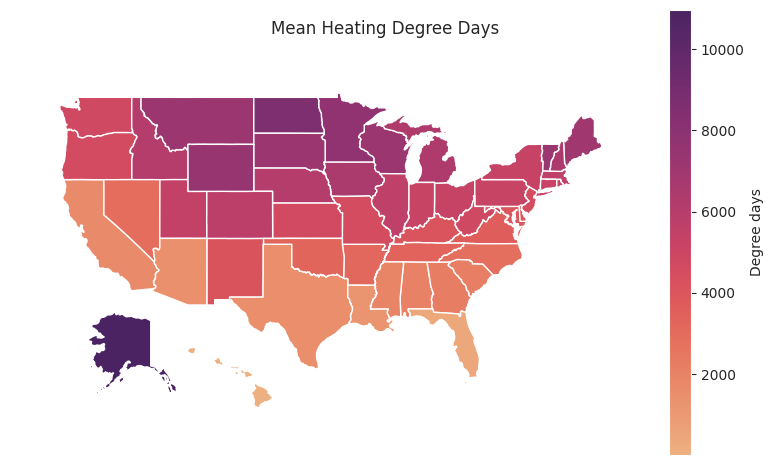

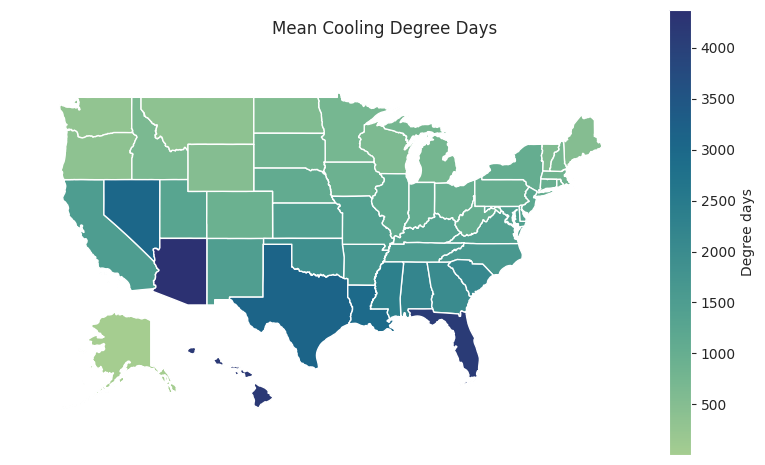

In [9]:
# HDD65, CDD65, DBT1, & DBT99 can all be inferred from the open-meteo API
weather_vars = meta.query("`section` == 'WEATHER'")["variable"].tolist()
weather_vars = [
    var for var in weather_vars if var not in ["HDD30YR_PUB", "CDD30YR_PUB", "GWT"]
]

# Plot degree days by state
plot_geo("HDD65", "Mean Heating Degree Days", "Degree days")
plot_geo("CDD65", "Mean Cooling Degree Days", "Degree days", "crest")

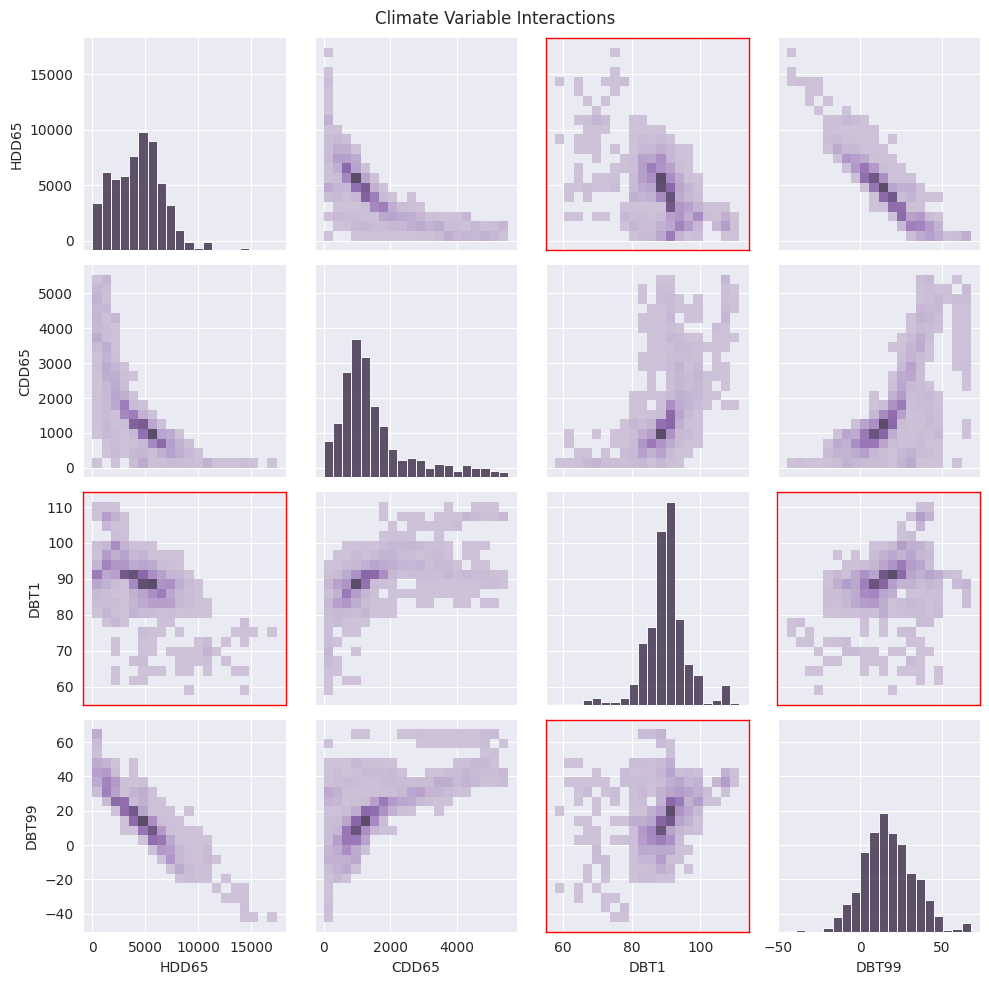

In [10]:
# Plot climate variable interactions
g = sns.PairGrid(data=households, vars=weather_vars)
g.map_diag(sns.histplot, bins=20)
g.map_offdiag(sns.histplot, bins=20)
g.fig.suptitle("Climate Variable Interactions")
g.fig.tight_layout()

# Highlight that DBT1 is the only variable with visibly weak correlations to its neighbors:
for i, j in [(0, 2), (2, 0), (2, 3), (3, 2)]:
    ax = g.axes[i, j]
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("red")
        spine.set_linewidth(1)

plt.show()

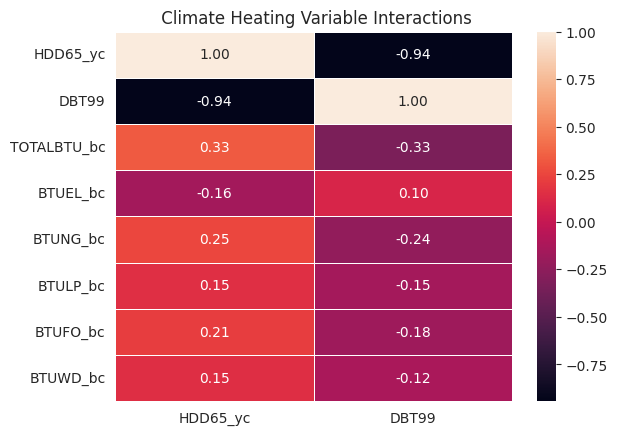

In [11]:
# Transform long-tailed degree-day variables
for col in ["CDD65", "HDD65"]:
    transformed, lmda = yeojohnson(households[col])
    households[f"{col}_yc"] = transformed
    households[f"{col}_lambda"] = [lmda] * len(households)


def plot_weather_corr(cols, title):
    corr = households[cols + target_vars_bc].corr()
    corr = corr[cols]

    ax = sns.heatmap(corr, annot=True, fmt=".2f", linewidth=0.5)
    ax.set_title(title)
    plt.show()


# Plot heating climate features against targets, noting that heating design temperature is less correlated with heating degree days, and each
# interacts differently with targets
plot_weather_corr(["HDD65_yc", "DBT99"], " Climate Heating Variable Interactions")

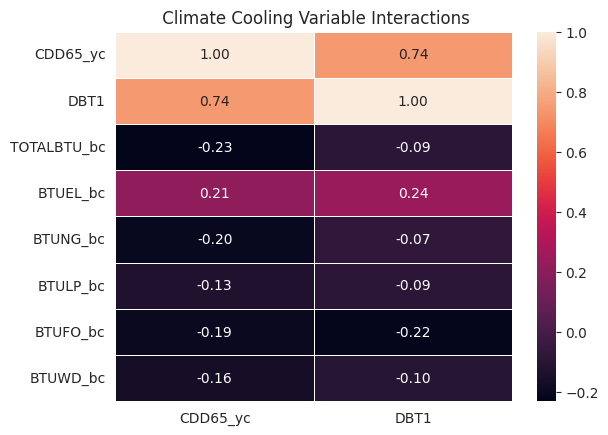

In [12]:
# Plot cooling climate features against targets, noting that cooling design temperature is highly correlated with cooling degree days, and
# each have similar interactions with targets
plot_weather_corr(["CDD65_yc", "DBT1"], " Climate Cooling Variable Interactions")

### Fuel variables

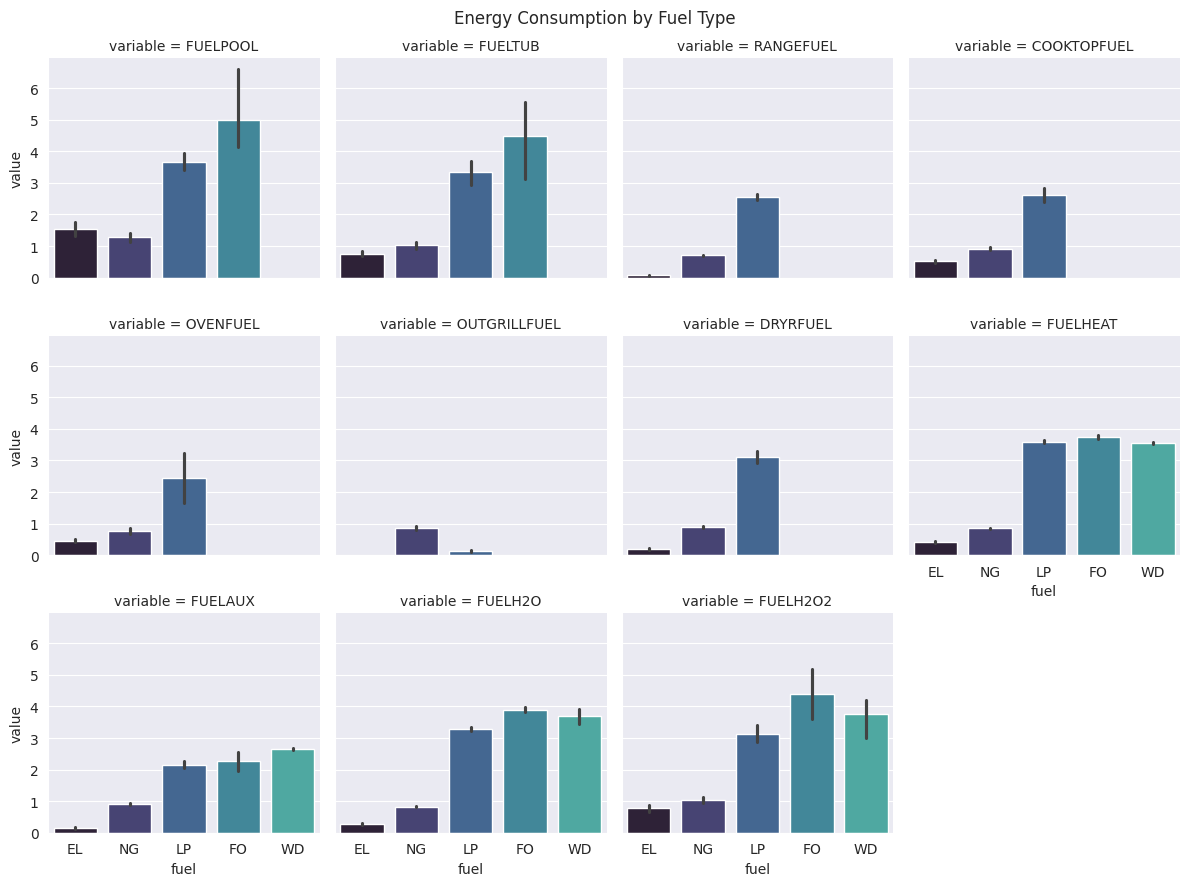

In [13]:
# Standardize target variables
for col in target_vars:
    households[f"{col}_std"] = StandardScaler().fit_transform(
        households[f"{col}_bc"].values.reshape(-1, 1)
    )

target_vars_std = [f"{col}_std" for col in target_vars]

fuel_vars = [
    "FUELPOOL",
    "FUELTUB",
    "RANGEFUEL",
    "COOKTOPFUEL",
    "OVENFUEL",
    "OUTGRILLFUEL",
    "DRYRFUEL",
    "FUELHEAT",
    "FUELAUX",
    "FUELH2O",
    "FUELH2O2",
]

# For each fuel feature variable, plot the mean standardized energy consumption of the corresponding fuel type
summary = pd.DataFrame(columns=["variable", "fuel", "value"])

for var in fuel_vars:
    melted = households.melt(
        id_vars=[var],
        value_vars=[v for v in target_vars_std if v != "TOTALBTU_std"],
        var_name="fuel",
    )
    melted[var] = (
        melted[var]
        .map(
            {
                0: np.nan,
                1: "BTUNG_std",
                2: "BTULP_std",
                3: "BTUFO_std",
                5: "BTUEL_std",
                7: "BTUWD_std",
            }
        )
        .dropna()
    )
    melted = melted[melted[var] == melted["fuel"]]
    melted = melted.drop(columns=[var])
    melted["fuel"] = melted["fuel"].map(lambda x: x[3:5])
    melted["variable"] = var
    summary = pd.concat([summary, melted], axis=0, ignore_index=True)

g = sns.catplot(
    data=summary,
    x="fuel",
    y="value",
    hue="fuel",
    col="variable",
    kind="bar",
    height=3,
    col_wrap=4,
    legend=False,
    sharex=True,
    sharey=True,
)
g.fig.suptitle(f"Energy Consumption by Fuel Type")
g.fig.tight_layout()
plt.show()

### Home variables

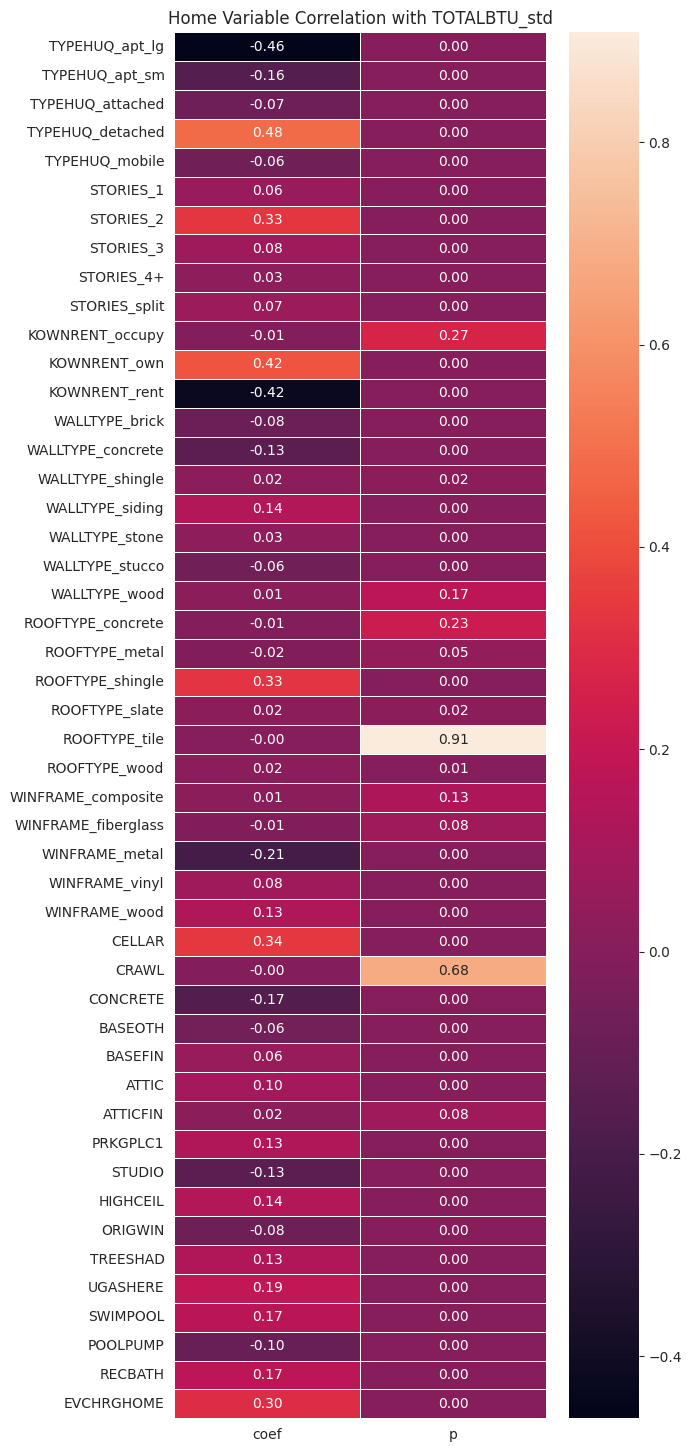

In [14]:
home_vars = meta.query("`section` == 'YOUR HOME'")["variable"].tolist()

# Encode categorical variables as strings
home = (
    households[home_vars + ["EVCHRGHOME", "TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "TYPEHUQ": {
                1: "mobile",
                2: "detached",
                3: "attached",
                4: "apt_sm",
                5: "apt_lg",
            },
            "STORIES": {1: "1", 2: "2", 3: "3", 4: "4+", 5: "split"},
            "KOWNRENT": {1: "own", 2: "rent", 3: "occupy"},
            "WALLTYPE": {
                1: "brick",
                2: "wood",
                3: "siding",
                4: "stucco",
                5: "shingle",
                6: "stone",
                7: "concrete",
                99: np.nan,
            },
            "ROOFTYPE": {
                1: "tile",
                2: "wood",
                3: "metal",
                4: "slate",
                5: "shingle",
                6: "concrete",
                99: np.nan,
            },
            "WINFRAME": {
                1: "wood",
                2: "metal",
                3: "vinyl",
                4: "composite",
                5: "fiberglass",
            },
        }
    )
)

home_categorical = [
    c for c in home_vars if c in categorical_vars and c not in fuel_vars
]
home_boolean = [
    c
    for c in home_vars + ["EVCHRGHOME"]
    if c in boolean_vars
    and c not in ["SQFTINCB", "SQFTINCA", "SQFTINCG"]  # Exclude derived variables
]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat(
    [pd.get_dummies(home[home_categorical]), home[home_boolean]], axis=1
)
corr = to_corr.corrwith(home["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Home Variable Correlation with TOTALBTU_std")
plt.show()

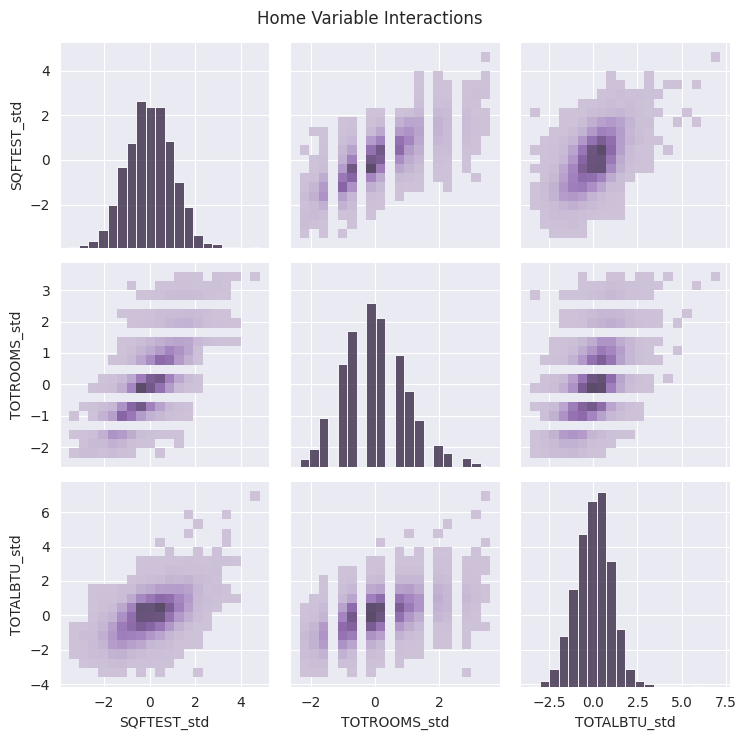

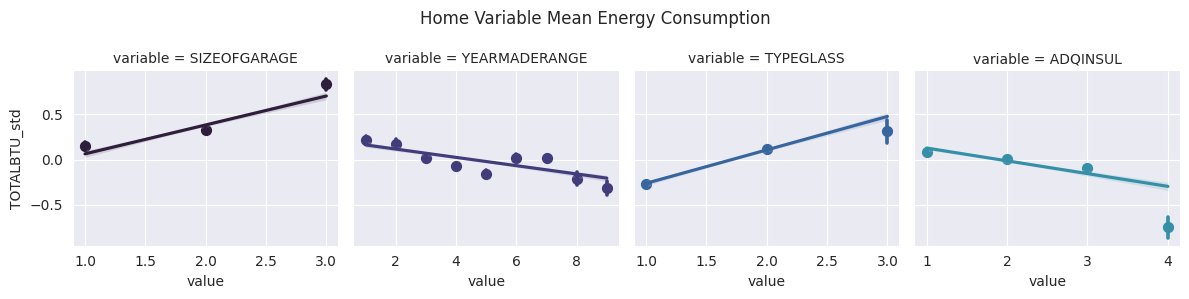

In [15]:
# Transform & standardize continuous home variables
transformed, lmda = boxcox(home["SQFTEST"])
home["SQFTEST_bc"] = transformed
home["SQFTEST_lambda"] = [lmda] * len(home)
home["SQFTEST_std"] = StandardScaler().fit_transform(
    home["SQFTEST_bc"].values.reshape(-1, 1)
)
home["TOTROOMS_std"] = StandardScaler().fit_transform(
    home["TOTROOMS"].values.reshape(-1, 1)
)

# Plot continuous home variable interactions
g = sns.PairGrid(data=home, vars=["SQFTEST_std", "TOTROOMS_std", "TOTALBTU_std"])
g.map_diag(sns.histplot, bins=20)
g.map_offdiag(sns.histplot, bins=20)
g.fig.suptitle("Home Variable Interactions")
g.fig.tight_layout()
plt.show()

home_numerical = [c for c in home_vars if c in numerical_vars]
home_ordinal = [c for c in home_vars if c in ordinal_vars]

# Plot a linear regression for select variables against standardized total consumption
melted = home.melt(
    id_vars=["TOTALBTU_std"],
    value_vars=["SIZEOFGARAGE", "YEARMADERANGE", "TYPEGLASS", "ADQINSUL"],
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    col_wrap=4,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Home Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Appliance variables

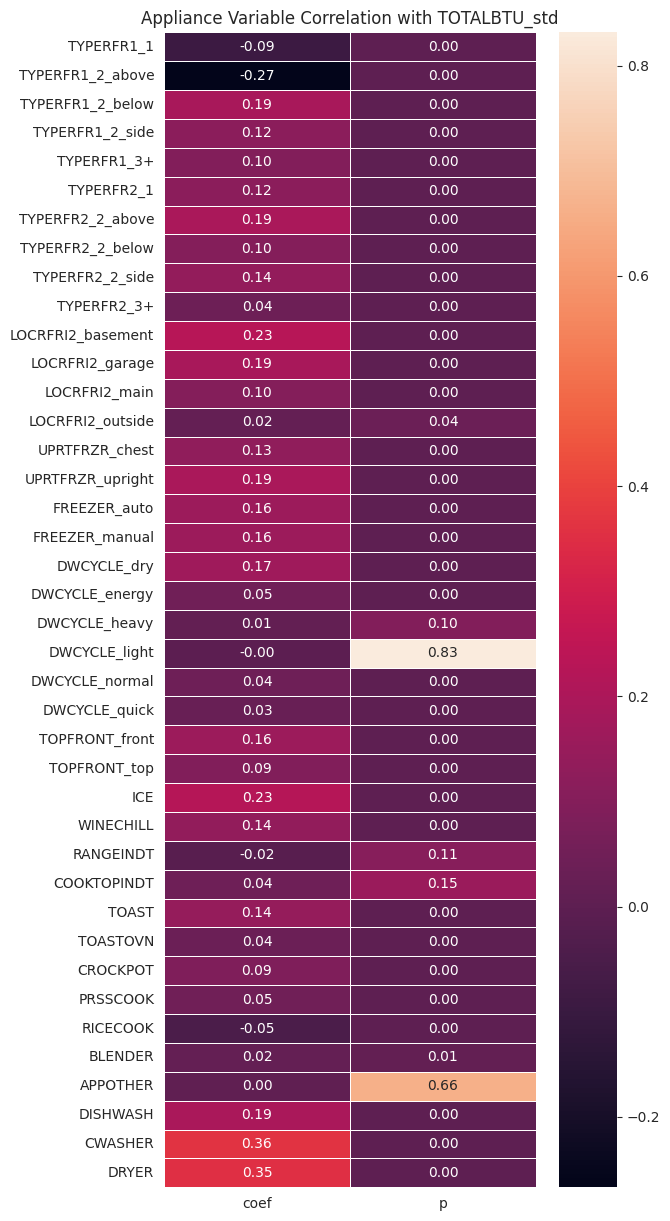

In [16]:
appliance_vars = meta.query("`section` == 'APPLIANCES'")["variable"].tolist()

# Encode categorical variables as strings, correct ordinal variable order
appliances = (
    households[appliance_vars + ["TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "TYPERFR1": {1: "1", 2: "2_side", 3: "2_above", 4: "2_below", 5: "3+"},
            "TYPERFR2": {1: "1", 2: "2_side", 3: "2_above", 4: "2_below", 5: "3+"},
            "LOCRFRI2": {
                1: "basement",
                2: "garage",
                3: "outside",
                4: "main",
                99: np.nan,
            },
            "UPRTFRZR": {1: "upright", 2: "chest"},
            "FREEZER": {1: "manual", 2: "auto"},
            "NUMMEAL": {0: 7},
            "USECOFFEE": {0: 3},
            "DWCYCLE": {
                1: "normal",
                2: "dry",
                3: "heavy",
                4: "light",
                5: "energy",
                6: "quick",
            },
            "TOPFRONT": {1: "top", 2: "front"},
            "WASHTEMP": {np.nan: 4},
        }
    )
)

appliances_categorical = [
    c for c in appliance_vars if c in categorical_vars and c not in fuel_vars
]
appliances_boolean = [
    c
    for c in appliance_vars
    if c in boolean_vars
    and c not in ["OUTGRILL", "ELFOOD", "LPCOOK", "UGCOOK"]  # Exclude derived variables
]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat(
    [
        pd.get_dummies(appliances[appliances_categorical]),
        appliances[appliances_boolean],
    ],
    axis=1,
)
corr = to_corr.corrwith(appliances["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Appliance Variable Correlation with TOTALBTU_std")
plt.show()

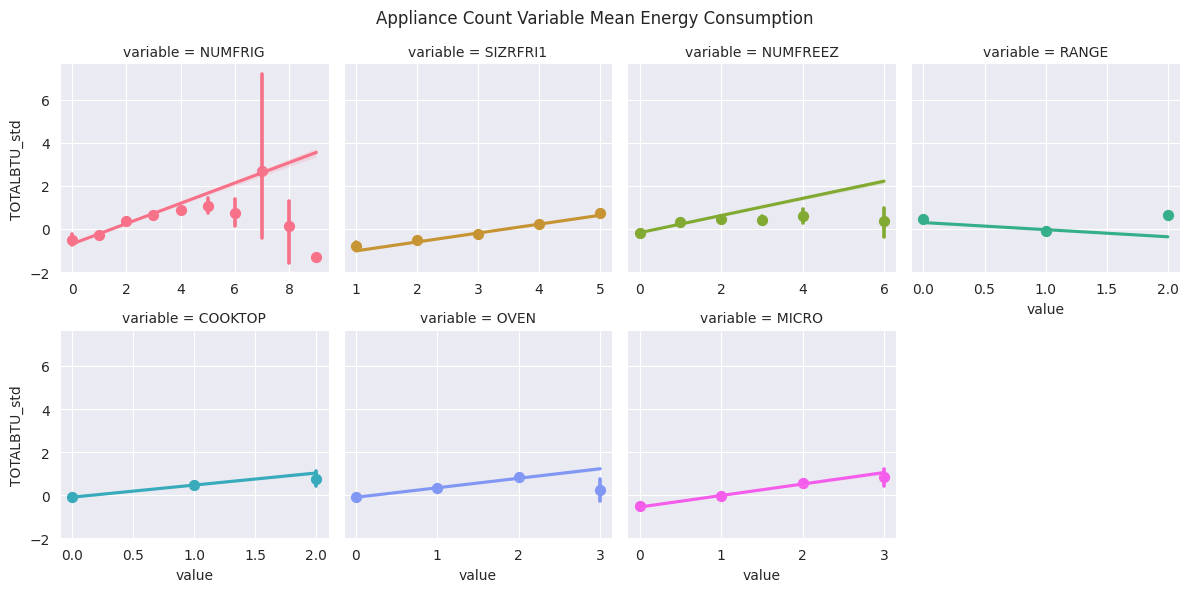

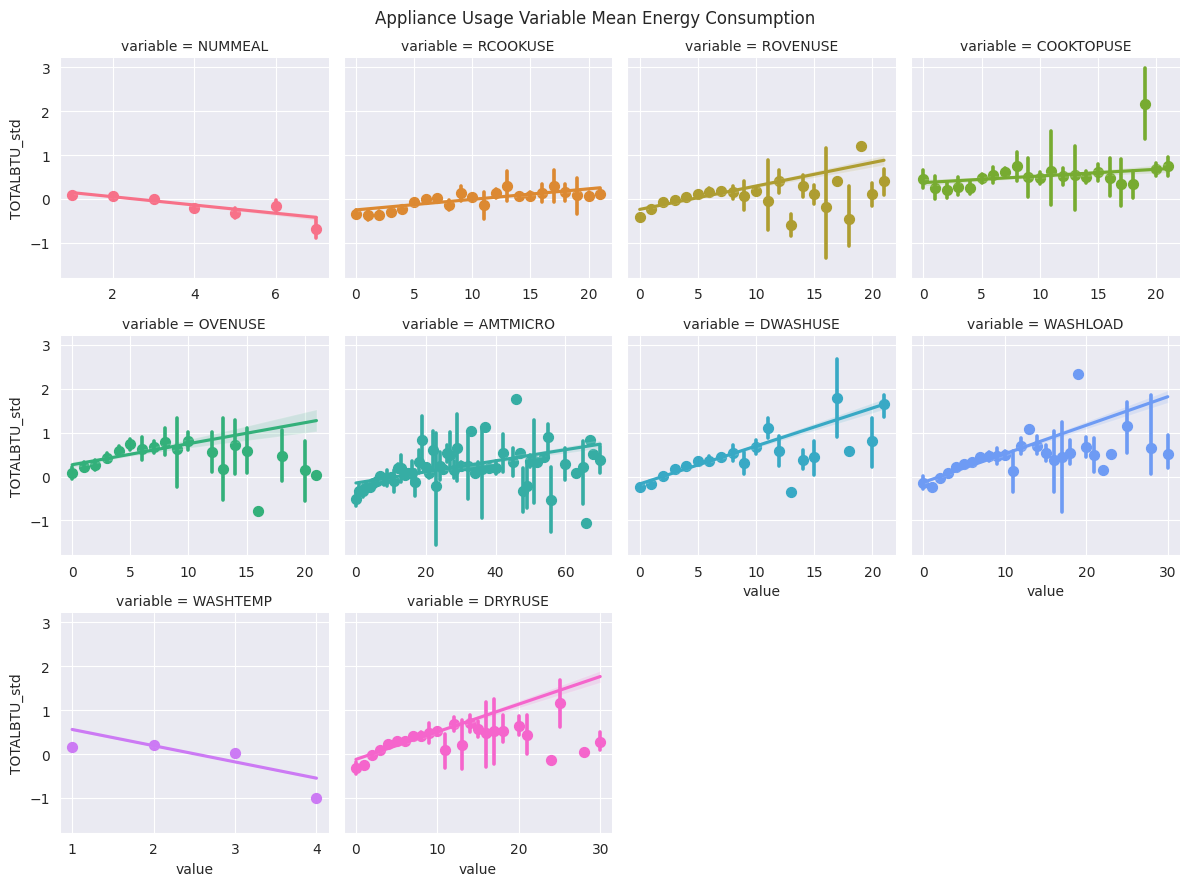

In [17]:
appliances_numerical = [c for c in appliance_vars if c in numerical_vars]
appliances_ordinal = [c for c in appliance_vars if c in ordinal_vars]

# Plot a linear regression for appliance count variables against standardized total consumption
melted = appliances.melt(
    id_vars=["TOTALBTU_std"],
    value_vars=["NUMFRIG", "SIZRFRI1", "NUMFREEZ", "RANGE", "COOKTOP", "OVEN", "MICRO"],
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    col_wrap=4,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Appliance Count Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

# Plot a linear regression for appliance usage variables against standardized total consumption
melted = appliances.melt(
    id_vars=["TOTALBTU_std"],
    value_vars=[
        "NUMMEAL",
        "RCOOKUSE",
        "ROVENUSE",
        "COOKTOPUSE",
        "OVENUSE",
        "AMTMICRO",
        "DWASHUSE",
        "WASHLOAD",
        "WASHTEMP",
        "DRYRUSE",
    ],
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    col_wrap=4,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Appliance Usage Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Air conditioning variables

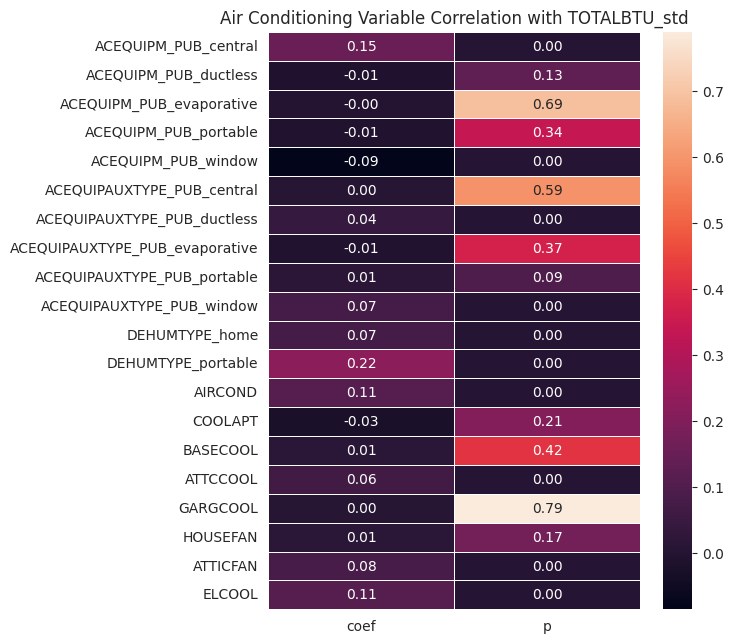

In [18]:
ac_vars = meta.query("`section` == 'AIR CONDITIONING'")["variable"].tolist()

# Encode categorical variables as strings
ac = (
    households[ac_vars + ["TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "ACEQUIPM_PUB": {
                1: "central",
                3: "ductless",
                4: "window",
                5: "portable",
                6: "evaporative",
            },
            "ACEQUIPAUXTYPE_PUB": {
                0: np.nan,
                1: "central",
                3: "ductless",
                4: "window",
                5: "portable",
                6: "evaporative",
            },
            "USECFAN": {99: np.nan},
            "DEHUMTYPE": {0: np.nan, 1: "portable", 2: "home"},
            "USEDEHUM": {99: np.nan},
        }
    )
)

ac_categorical = [c for c in ac_vars if c in categorical_vars]
ac_boolean = [c for c in ac_vars if c in boolean_vars]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat([pd.get_dummies(ac[ac_categorical]), ac[ac_boolean]], axis=1)
corr = to_corr.corrwith(ac["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Air Conditioning Variable Correlation with TOTALBTU_std")
plt.show()

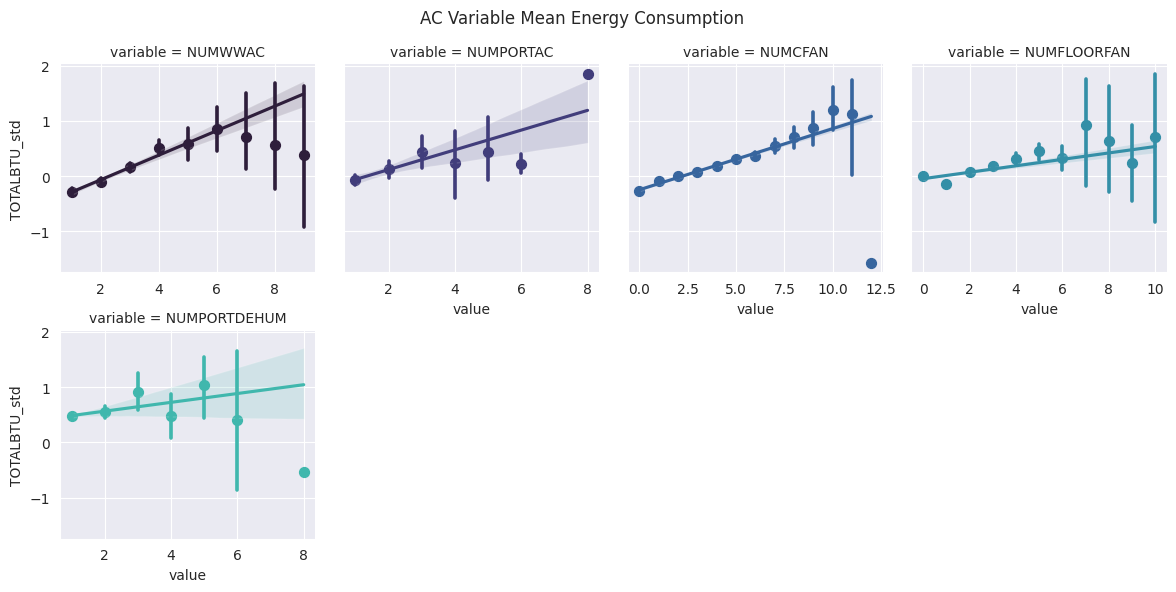

In [19]:
ac_numerical = [c for c in ac_vars if c in numerical_vars]
ac_ordinal = [c for c in ac_vars if c in ordinal_vars]

# Plot a linear regression for select variables against standardized total consumption
melted = ac.melt(
    id_vars=["TOTALBTU_std"],
    value_vars=["NUMWWAC", "NUMPORTAC", "NUMCFAN", "NUMFLOORFAN", "NUMPORTDEHUM"],
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    col_wrap=4,
    facet_kws={"sharex": False},
)
g.fig.suptitle("AC Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Heating variables

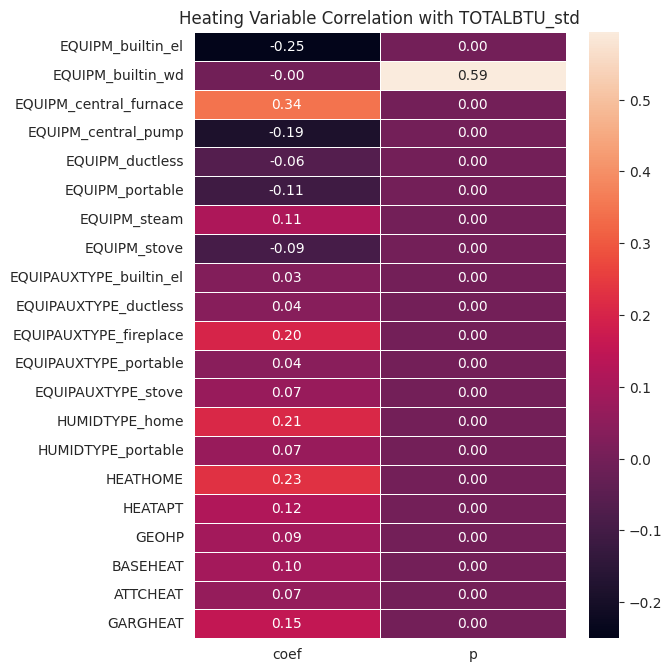

In [31]:
heating_vars = meta.query("`section` == 'SPACE HEATING'")["variable"].tolist()

# Encode categorical variables as strings
heating = (
    households[heating_vars + ["TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "EQUIPM": {
                2: "steam",
                3: "central_furnace",
                4: "central_pump",
                5: "builtin_el",
                7: "builtin_wd",
                8: "stove",
                10: "portable",
                13: "ductless",
                99: np.nan,
            },
            "EQUIPAUXTYPE": {
                0: np.nan,
                5: "builtin_el",
                8: "stove",
                9: "fireplace",
                10: "portable",
                13: "ductless",
                99: np.nan,
            },
            "HUMIDTYPE": {0: np.nan, 1: "portable", 2: "home"},
            "USEHUMID": {99: np.nan},
        }
    )
)

heating_categorical = [
    c
    for c in heating_vars
    if c in categorical_vars and c != "DNTHEAT" and c not in fuel_vars
]
heating_boolean = [
    c
    for c in heating_vars
    if c in boolean_vars
    and c
    not in [
        "EQUIPAUX",
        "ELWARM",
        "UGWARM",
        "LPWARM",
        "FOWARM",
        "WDWARM",
    ]  # Exclude derived variables
]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat(
    [pd.get_dummies(heating[heating_categorical]), heating[heating_boolean]], axis=1
)
corr = to_corr.corrwith(heating["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Heating Variable Correlation with TOTALBTU_std")
plt.show()

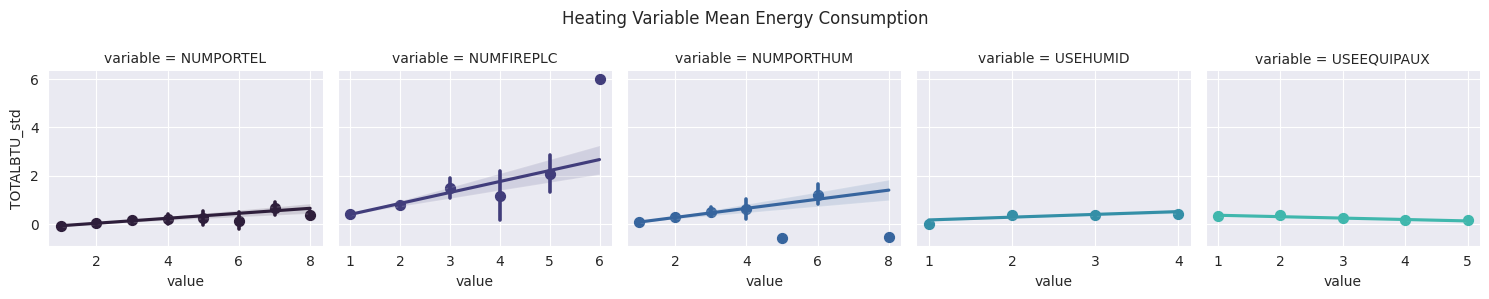

In [32]:
heating_numerical = [c for c in heating_vars if c in numerical_vars]
heating_ordinal = [c for c in heating_vars if c in ordinal_vars]

# Plot a linear regression for select variables against standardized total consumption
melted = heating.melt(
    id_vars=["TOTALBTU_std"],
    value_vars=["NUMPORTEL", "NUMFIREPLC", "NUMPORTHUM", "USEHUMID", "USEEQUIPAUX"],
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Heating Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Water heating variables

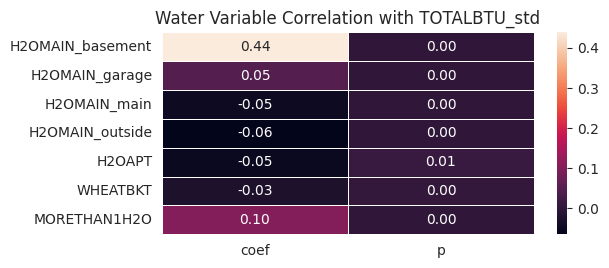

In [22]:
water_vars = meta.query("`section` == 'WATER HEATING'")["variable"].tolist()

# Encode categorical variables as strings
water = (
    households[water_vars + ["TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "H2OMAIN": {
                1: "main",
                2: "basement",
                3: "garage",
                4: "outside",
                99: np.nan,
            },
        }
    )
)

water_categorical = [
    c for c in water_vars if c in categorical_vars and c not in fuel_vars
]
water_boolean = [
    c
    for c in water_vars
    if c in boolean_vars
    and c
    not in [
        "ELWATER",
        "FOWATER",
        "LPWATER",
        "SOLWATER",
        "WDWATER",
        "UGWATER",
    ]  # Exclude derived variables
]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat(
    [pd.get_dummies(water[water_categorical]), water[water_boolean]], axis=1
)
corr = to_corr.corrwith(water["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Water Variable Correlation with TOTALBTU_std")
plt.show()

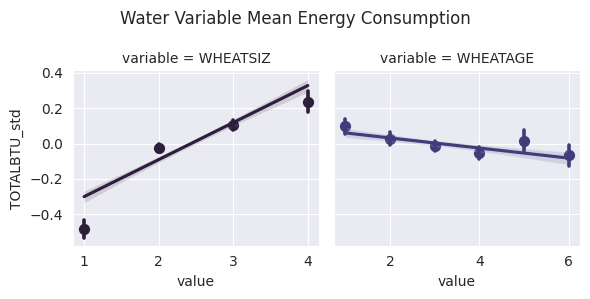

In [23]:
water_numerical = [c for c in water_vars if c in numerical_vars]
water_ordinal = [c for c in water_vars if c in ordinal_vars]

# Plot a linear regression for select variables against standardized total consumption
melted = water.melt(
    id_vars=["TOTALBTU_std"], value_vars=water_numerical + water_ordinal
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Water Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Electronics variables

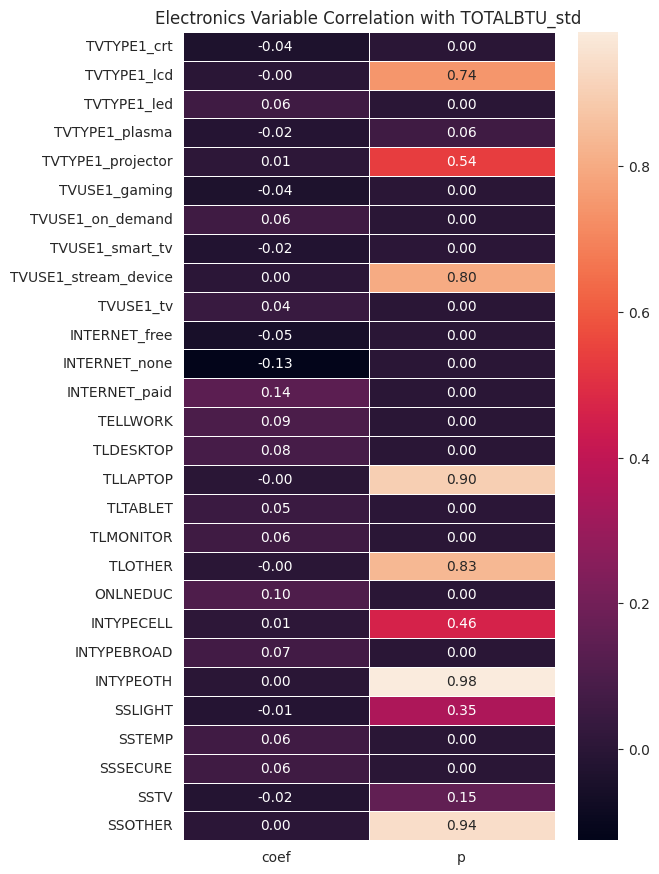

In [24]:
electronics_vars = meta.query("`section` == 'ELECTRONICS'")["variable"].tolist()

# Encode categorical variables as strings
electronics = (
    households[electronics_vars + ["TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "TVTYPE1": {1: "led", 2: "lcd", 3: "plasma", 4: "projector", 5: "crt"},
            "TVUSE1": {
                1: "tv",
                2: "on_demand",
                3: "smart_tv",
                4: "stream_device",
                5: "gaming",
                99: np.nan,
            },
            "TVTYPE2": {1: "led", 2: "lcd", 3: "plasma", 4: "projector", 5: "crt"},
            "TVUSE2": {
                1: "tv",
                2: "on_demand",
                3: "smart_tv",
                4: "stream_device",
                5: "gaming",
                99: np.nan,
            },
            "TVTYPE3": {1: "led", 2: "lcd", 3: "plasma", 4: "projector", 5: "crt"},
            "TVUSE3": {
                1: "tv",
                2: "on_demand",
                3: "smart_tv",
                4: "stream_device",
                5: "gaming",
                99: np.nan,
            },
            "INTERNET": {0: "none", 1: "paid", 2: "free"},
        }
    )
)

electronics_categorical = [c for c in electronics_vars if c in categorical_vars]
electronics_boolean = [c for c in electronics_vars if c in boolean_vars]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat(
    [
        pd.get_dummies(electronics[electronics_categorical]),
        electronics[electronics_boolean],
    ],
    axis=1,
)
corr = to_corr.corrwith(electronics["TOTALBTU_std"], method=pointbiserialr)
corr.drop(
    list(corr.filter(regex="^TV.*(2|3)_")), axis=1, inplace=True
)  # Exclude 2nd & 3rd TV categories
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Electronics Variable Correlation with TOTALBTU_std")
plt.show()

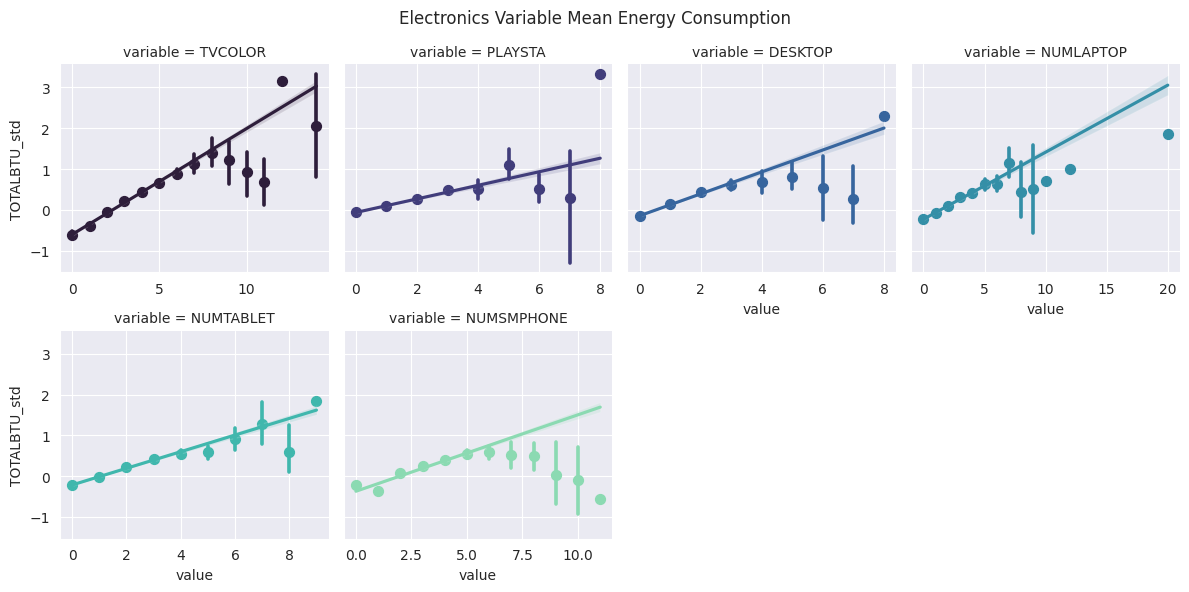

In [25]:
electronics_numerical = [c for c in electronics_vars if c in numerical_vars]
electronics_ordinal = [c for c in electronics_vars if c in ordinal_vars]

# Plot a linear regression for select variables against standardized total consumption
melted = electronics.melt(
    id_vars=["TOTALBTU_std"],
    value_vars=[
        "TVCOLOR",
        "PLAYSTA",
        "DESKTOP",
        "NUMLAPTOP",
        "NUMTABLET",
        "NUMSMPHONE",
    ],
)
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    col_wrap=4,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Electronics Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Thermostat variables

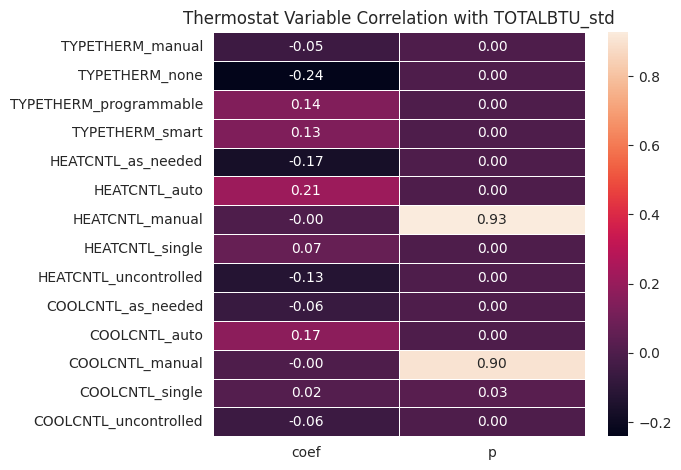

In [26]:
thermo_vars = meta.query("`section` == 'THERMOSTAT'")["variable"].tolist()

# Encode categorical variables as strings
thermo = (
    households[thermo_vars + ["TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "TYPETHERM": {0: "none", 1: "manual", 2: "programmable", 3: "smart"},
            "HEATCNTL": {
                1: "single",
                2: "manual",
                3: "auto",
                4: "as_needed",
                5: "uncontrolled",
                99: np.nan,
            },
            "COOLCNTL": {
                1: "single",
                2: "manual",
                3: "auto",
                4: "as_needed",
                5: "uncontrolled",
                99: np.nan,
            },
        }
    )
)

thermo_categorical = [c for c in thermo_vars if c in categorical_vars]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.get_dummies(thermo[thermo_categorical])
corr = to_corr.corrwith(thermo["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Thermostat Variable Correlation with TOTALBTU_std")
plt.show()

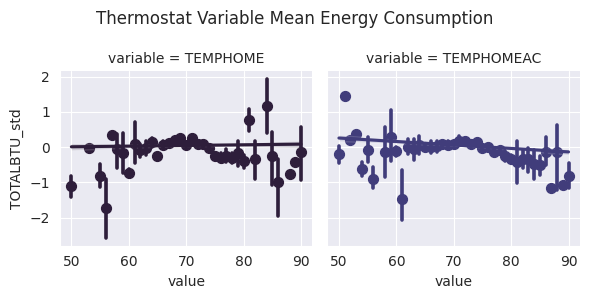

In [27]:
thermo_numerical = [c for c in thermo_vars if c in numerical_vars]

# Plot a linear regression for select variables against standardized total consumption
melted = thermo.melt(id_vars=["TOTALBTU_std"], value_vars=["TEMPHOME", "TEMPHOMEAC"])
g = sns.lmplot(
    data=melted,
    x="value",
    y="TOTALBTU_std",
    col="variable",
    hue="variable",
    x_estimator=np.mean,
    legend=False,
    height=3,
    facet_kws={"sharex": False},
)
g.fig.suptitle("Thermostat Variable Mean Energy Consumption")
g.fig.tight_layout()
plt.show()

### Demographic variables

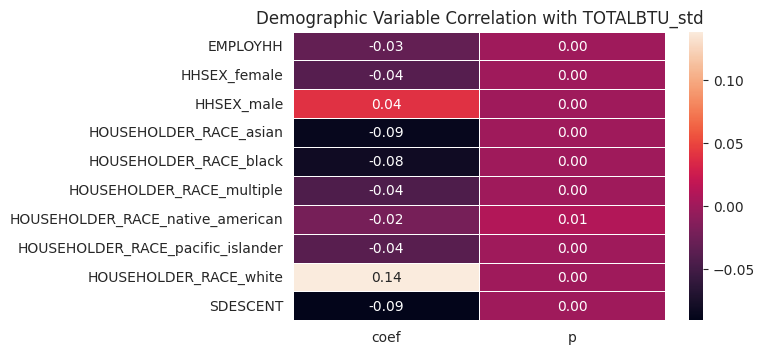

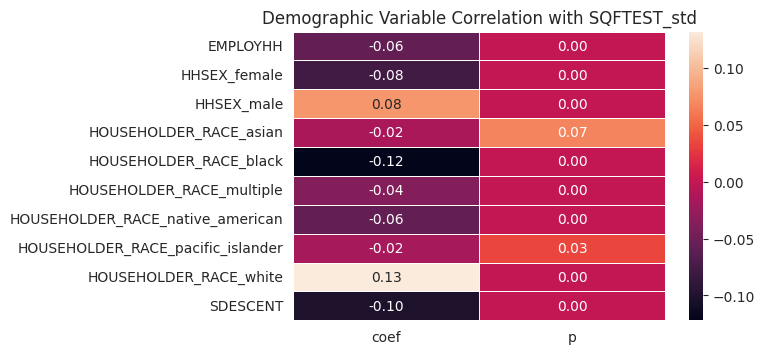

In [28]:
demo_vars = meta.query("`section` == 'HOUSEHOLD CHARACTERISTICS'")["variable"].tolist()

# Encode categorical variables as strings
demo = (
    households[demo_vars + ["SQFTEST", "TOTALBTU_std"]]
    .copy()
    .replace(
        {
            "HHSEX": {1: "female", 2: "male"},
            "HOUSEHOLDER_RACE": {
                1: "white",
                2: "black",
                3: "native_american",
                4: "asian",
                5: "pacific_islander",
                6: "multiple",
            },
        }
    )
)

demo_categorical = [c for c in demo_vars if c in categorical_vars]
demo_boolean = [c for c in demo_vars if c in boolean_vars]

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against total energy consumption
to_corr = pd.concat(
    [pd.get_dummies(demo[demo_categorical]), demo[demo_boolean]], axis=1
)
corr = to_corr.corrwith(demo["TOTALBTU_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(to_corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Demographic Variable Correlation with TOTALBTU_std")
plt.show()

# Box-cox transform & standardize square footage
transformed, lmda = boxcox(demo["SQFTEST"])
demo["SQFTEST_bc"] = transformed
demo["SQFTEST_lambda"] = [lmda] * len(home)
demo["SQFTEST_std"] = StandardScaler().fit_transform(
    demo["SQFTEST_bc"].values.reshape(-1, 1)
)

# Plot the point-biserial correlation of each one-hot encoded categorical & boolean variable against home square footage
to_corr = pd.concat(
    [pd.get_dummies(demo[demo_categorical]), demo[demo_boolean]], axis=1
)
corr = to_corr.corrwith(demo["SQFTEST_std"], method=pointbiserialr)
plt.figure(figsize=(6, len(to_corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=0.5)
ax.set_xticklabels(["coef", "p"])
ax.set_title("Demographic Variable Correlation with SQFTEST_std")
plt.show()

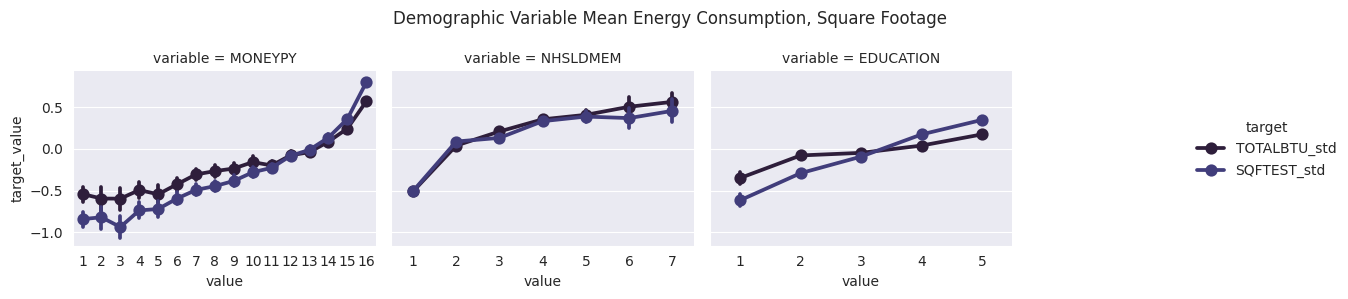

In [29]:
# Plot select variables against both standardized total consumption and standardized home square footage, to demonstrate demographic effects
# caused by home size disparities
melted = demo.melt(
    id_vars=["TOTALBTU_std", "SQFTEST_std"],
    value_vars=["MONEYPY", "NHSLDMEM", "EDUCATION"],
)
melted = melted.melt(
    id_vars=["variable", "value"],
    value_vars=["TOTALBTU_std", "SQFTEST_std"],
    var_name="target",
    value_name="target_value",
)
g = sns.catplot(
    data=melted,
    x="value",
    y="target_value",
    col="variable",
    hue="target",
    kind="point",
    height=3,
    col_wrap=4,
    legend=True,
    sharey=True,
    sharex=False,
)
g.fig.suptitle("Demographic Variable Mean Energy Consumption, Square Footage")
g.fig.tight_layout()
plt.show()